In [ ]:
# we will need to manually add labels for color, since all we have right now is species.
# Eventually - cut off confidence threshold to handle pictures that don't have a flower
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from ultralytics import YOLO
import torch
import csv

# function to initialize our pretrained segmentation model - this will get flower masks
def initialize_segmentation_model(path):
    model = YOLO(path)
    model.eval()
    return model

# this will extract the flower from the original image using masking and 
def segment_flower(image_path, model, name):
    img_bgr = cv2.imread(image_path)
    # convert bgr to rgb, rescale, resize to match model expectation
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype('float32') / 255.0
    img_rgb = cv2.resize(img_rgb, (640,640))
    img_tensor = torch.from_numpy(img_rgb).permute((2,0,1)).unsqueeze(0)
    #print(img_tensor.shape)
    #print(img_rgb.min(), img_rgb.max(), img_rgb.dtype)

    # predict result
    results = model.predict(img_tensor, conf=0.05, save=False, show=True)
    r = results[0]

    # if we don't find any boxes - we want to be able to flag it and return some kind of error
    error = False
    if len(r.boxes) == 0:
        print("No flowers here, fam")
        error = True
        return None, None, None, None

    # identify highest scoring mask
    scores = r.boxes.conf.cpu().numpy()
    idx_max = scores.argmax()
    annotated = r.orig_img.copy()

    # if we have a mask, we want to color it in on the original image
    if r.masks is not None:
        best_mask = r.masks.data[idx_max].cpu().numpy()  # (H, W)
        best_mask = cv2.resize(best_mask, (annotated.shape[1], annotated.shape[0]))  # match original image

        binary_mask = (best_mask > 0.5).astype(np.uint8)
        #overlay = annotated.copy()
        #overlay[binary_mask== 1] = (0,255,0)

        # blend with original image
        #annotated = cv2.addWeighted(annotated, 0.7, overlay, 1.0, 0)

        # also draw bounding box, why not
        #box = r.boxes.xyxy[idx_max].cpu().numpy().astype(int)
        #cv2.rectangle(annotated, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    else:
        print("No masks found for this detection.")
        #annotated = r.plot()

    #print(annotated.shape)
    #annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    #plt.imshow(annotated_rgb)
    #plt.axis("off")
    #plt.show()

    binary_mask = np.stack([binary_mask]*3, axis=-1)
    flower = img_rgb * binary_mask
    #print(flower.shape)
    #plt.imshow(flower)
    #plt.show()

    mask_path = f'masks/{name}.pt'
    torch.save(binary_mask, mask_path)

    return flower, binary_mask, mask_path, error

# this one will apply kmeans to our extracted flower to determine its most common color
def dominant_color(k, flower, mask):
    if mask.ndim == 3:
        mask_gray = mask[..., 0]
    else:
        mask_gray = mask

    # convert to LAB color - more similar to human perception of color
    flower_uint8 = (flower * 255).astype(np.uint8)
    flower_lab = cv2.cvtColor(flower_uint8, cv2.COLOR_RGB2LAB)

    # extract pixels
    pixels = flower_lab[mask_gray > 0]
    if len(pixels) == 0:
        print("No valid pixels found in mask.")
        return None

    # apply kmeans
    kmeans = KMeans(n_clusters=k, random_state=25).fit(pixels)
    labels, centers = kmeans.labels_, kmeans.cluster_centers_

    # count how many pixels were clustered into each group
    counts = np.bincount(labels)
    dominant_idx = np.argmax(counts)
    dominant_lab = centers[dominant_idx]
    return dominant_lab

    '''sorted_idx = np.argsort(-counts)

    # sort 
    centers = centers[sorted_idx]
    counts = counts[sorted_idx]

    # back to RGB for visualization
    rgb_centers = cv2.cvtColor(np.uint8(centers[np.newaxis, :, :]), cv2.COLOR_LAB2RGB)[0]

    # display colors and frequencies
    plt.figure(figsize=(8, 2))
    for i, (color, freq) in enumerate(zip(rgb_centers, counts)):
        patch = np.ones((50, 50, 3), dtype=np.uint8) * color
        plt.subplot(1, k, i+1)
        plt.imshow(patch)
        plt.title(f"{freq}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # return sorted color centers and frequencies
    return rgb_centers, counts

    # grab cenrtoids and counts
    centroids = []
    for cluster_index, count in enumerate(counts):
        centroids.append((centers[cluster_index], int(count)))

    for i in range(k):
        color = centroids[i][0]
        frequency = centroids[i][1]
        #print(frequency)
        color = np.uint8([[color]])
        rgb = cv2.cvtColor(color, cv2.COLOR_HSV2RGB)
        #print(rgb)
        box = np.zeros((10,10,3), dtype=np.uint8)
        box[:,:] = rgb

        plt.subplot(1,k,i+1); plt.imshow(box); plt.title(frequency)
        
    plt.show()'''


# initialize pretrained model
model = initialize_segmentation_model("flowers_segmentation_model.pt")

# get our list of flower folders
image_paths = os.listdir(f'flowers')
print(image_paths)

# create csv to save image paths and data
images = open('images.csv', mode='w', newline='')
csv_writer = csv.writer(images)
csv_writer.writerow(['Path', 'Mask Path', 'Species', 'LAB Color'])

# create csv to save issue images
empty_images = open('empty_images.csv', mode='w', newline='')
csv_writer_err = csv.writer(empty_images)
csv_writer_err.writerow(['Path', 'Mask Path', 'Species', 'LAB Color'])

# set k parameter and initialize list to save colros
k = 3
dominant_colors = []

# iterate over our image paths and write to our csv
for i in range(len(image_paths)):
    species = image_paths[i]
    species_list = os.listdir('flowers/' + species)
    for j in range(len(species_list)):
        image_path = 'flowers/' + species + '/' + species_list[j]
        image_name = f'{species}_{species_list[j]}'
        image_name = image_name[:-4]

        flower, binary_mask, mask_path, error = segment_flower(image_path, model, image_name)

        #print(image_name)
        #print(mask_path)
        #print(species)
        if error == None:
            continue
        dominant_lab = dominant_color(k, flower, binary_mask)

        if error == False:
            csv_writer.writerow([image_path, mask_path, species, dominant_lab])
        else:
            csv_writer_err.writerow([image_path, mask_path, species, dominant_lab])
        
        dominant_colors.append(dominant_lab)
        #break
    break

images.close()
empty_images.close()

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']



0: 640x640 10 Acauliss, 2 Dandelions, 1 bearded_iris, 59.4ms
Speed: 1.9ms preprocess, 59.4ms inference, 40.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 Acauliss, 2 Dandelions, 55.4ms
Speed: 2.2ms preprocess, 55.4ms inference, 37.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Acauliss, 22.6ms
Speed: 1.4ms preprocess, 22.6ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 22.5ms
Speed: 1.3ms preprocess, 22.5ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 2 Dandelions, 1 cape_flower, 22.7ms
Speed: 1.4ms preprocess, 22.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 4 Acauliss, 22.5ms
Speed: 1.3ms preprocess, 22.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Acauliss, 57.8ms
Speed: 2.1ms preprocess, 57.8ms inference, 14.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 57.8ms
Speed: 1.9ms preprocess, 57.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 23 Acauliss, 1 Curcuma, 1 Dandelion, 57.6ms
Speed: 2.1ms preprocess, 57.6ms inference, 53.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 cape_flower, 57.3ms
Speed: 2.1ms preprocess, 57.3ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 57.5ms
Speed: 2.1ms preprocess, 57.5ms inference, 12.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 Acauliss, 1 Dandelion, 57.1ms
Speed: 2.1ms preprocess, 57.1ms inference, 30.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 4 Dandelions, 1 bearded_i

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 22 Acauliss, 1 Doraji, 1 cape_flower, 55.2ms
Speed: 2.1ms preprocess, 55.2ms inference, 51.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 21.8ms
Speed: 1.3ms preprocess, 21.8ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 22.4ms
Speed: 1.5ms preprocess, 22.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Acauliss, 22.0ms
Speed: 1.3ms preprocess, 22.0ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Acauliss, 22.0ms
Speed: 1.3ms preprocess, 22.0ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 20 Acauliss, 1 Doraji, 1 Geumeocho, 56.6ms
Speed: 2.1ms preprocess, 56.6ms inference, 47.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Acauliss, 22.6ms
Speed: 1.3ms preprocess, 22.6ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Acauliss, 1 Curcuma, 1 Doraji, 1 Geum

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 7 Acauliss, 1 cape_flower, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 20.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 bearded_iris, 1 camellia, 56.3ms
Speed: 2.1ms preprocess, 56.3ms inference, 11.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bearded_iris, 56.3ms
Speed: 2.1ms preprocess, 56.3ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 bearded_iris, 1 camellia, 56.4ms
Speed: 2.1ms preprocess, 56.4ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 1 Dandelion, 1 Doraji, 56.3ms
Speed: 2.0ms preprocess, 56.3ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Dandelion, 2 Dorajis, 1 bearded_iris, 56.6ms
Speed: 2.1ms preprocess, 56.6ms inference, 13.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 1 Curcuma, 1 cape_flower, 55.9ms
Speed: 2.1ms preprocess, 55.9ms infer

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 21 Acauliss, 1 Dandelion, 57.3ms
Speed: 2.1ms preprocess, 57.3ms inference, 47.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 54.9ms
Speed: 2.1ms preprocess, 54.9ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cape_flower, 55.1ms
Speed: 1.9ms preprocess, 55.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 54.9ms
Speed: 2.1ms preprocess, 54.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 (no detections), 54.7ms
Speed: 2.1ms preprocess, 54.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 1 Acaulis, 2 bearded_iriss, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Acauliss, 57.8ms
Speed: 1.9ms preprocess, 57.8ms inference, 16.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Aca

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 5 Acauliss, 2 Dandelions, 16.9ms
Speed: 0.9ms preprocess, 16.9ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Dandelion, 1 Nigella, 27.3ms
Speed: 1.2ms preprocess, 27.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bommaji, 1 Dandelion, 27.8ms
Speed: 1.2ms preprocess, 27.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Dandelions, 28.3ms
Speed: 1.3ms preprocess, 28.3ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 2 Dandelions, 1 Lentenrose, 1 bearded_iris, 28.3ms
Speed: 1.4ms preprocess, 28.3ms inference, 12.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Dandelion, 1 Nigella, 28.3ms
Speed: 1.3ms preprocess, 28.3ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 57.9ms
Speed: 2.1ms preprocess, 57.9ms inference, 4.3ms postprocess per image at shape (1, 3, 64

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


0: 640x640 1 Doraji, 2 cape_flowers, 23.5ms
Speed: 1.4ms preprocess, 23.5ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 23.5ms
Speed: 1.2ms preprocess, 23.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 Acauliss, 1 Carnation, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 26.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Curcuma, 3 Geumeochos, 57.3ms
Speed: 2.0ms preprocess, 57.3ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 Acauliss, 1 Doraji, 1 bougainvillea, 56.6ms
Speed: 2.1ms preprocess, 56.6ms inference, 40.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 cape_flower, 56.5ms
Speed: 2.1ms preprocess, 56.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


0: 640x640 26 Acauliss, 5 Curcumas, 4 Geumeochos, 1 Geumggyeguk, 1 GgangGgangyee, 56.3ms
Speed: 2.1ms preprocess, 56.3ms inference, 76.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Doraji, 22.1ms
Speed: 1.2ms preprocess, 22.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cape_flower, 22.2ms
Speed: 1.3ms preprocess, 22.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 Acauliss, 22.1ms
Speed: 1.3ms preprocess, 22.1ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 Acauliss, 2 Dandelions, 2 lotuss, 22.1ms
Speed: 1.3ms preprocess, 22.1ms inference, 24.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 21 Acauliss, 2 Dandelions, 55.2ms
Speed: 2.1ms preprocess, 55.2ms inference, 48.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Acauliss, 10 lotuss, 21.7ms
Speed: 1.3ms preprocess, 21.7ms inference, 18.9ms postprocess per image at s

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 3 Acauliss, 10 lotuss, 21.7ms
Speed: 1.3ms preprocess, 21.7ms inference, 18.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 Acauliss, 2 Dandelions, 2 lotuss, 57.0ms
Speed: 2.1ms preprocess, 57.0ms inference, 39.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Acauliss, 23.6ms
Speed: 1.3ms preprocess, 23.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 2 cape_flowers, 23.6ms
Speed: 1.3ms preprocess, 23.6ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 Acauliss, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Doraji, 1 cape_flower, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 57.5ms
Speed: 2.1ms preprocess, 57.5ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Acauliss, 1 Artichoke,

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 7 Dandelions, 1 camellia, 54.9ms
Speed: 2.1ms preprocess, 54.9ms inference, 26.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 56.2ms
Speed: 2.1ms preprocess, 56.2ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 56.9ms
Speed: 1.9ms preprocess, 56.9ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 57.9ms
Speed: 2.1ms preprocess, 57.9ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 Acauliss, 1 Doraji, 58.1ms
Speed: 2.1ms preprocess, 58.1ms inference, 25.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Acauliss, 1 Dandelion, 2 lotuss, 58.0ms
Speed: 14.9ms preprocess, 58.0ms inference, 26.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Acauliss, 1 Geumeocho, 1 cape_flower, 55.9ms
Speed: 2.1ms preprocess, 55.9ms inference, 21.3ms postprocess per image at shape (1, 3, 640, 640)



c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


0: 640x640 8 Acauliss, 55.2ms
Speed: 1.9ms preprocess, 55.2ms inference, 21.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 2 Dandelions, 4 lotuss, 55.4ms
Speed: 2.2ms preprocess, 55.4ms inference, 23.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 23.4ms
Speed: 1.3ms preprocess, 23.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 bougainvillea, 23.4ms
Speed: 1.3ms preprocess, 23.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 23.2ms
Speed: 1.3ms preprocess, 23.2ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.3ms
Speed: 1.3ms preprocess, 23.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 1 Acaulis, 57.5ms
Speed: 2.1ms preprocess, 57.5ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 2 Dandelions, 57

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


0: 640x640 3 Acauliss, 2 Geumeochos, 1 cape_flower, 22.7ms
Speed: 1.3ms preprocess, 22.7ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Acauliss, 22.6ms
Speed: 1.3ms preprocess, 22.6ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 2 Geumeochos, 1 cape_flower, 22.6ms
Speed: 1.3ms preprocess, 22.6ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Acauliss, 1 bougainvillea, 22.6ms
Speed: 1.3ms preprocess, 22.6ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 cape_flower, 57.8ms
Speed: 2.1ms preprocess, 57.8ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cape_flower, 58.1ms
Speed: 2.1ms preprocess, 58.1ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 57.9ms
Speed: 2.1ms preprocess, 57.9ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


0: 640x640 (no detections), 57.9ms
Speed: 2.1ms preprocess, 57.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 3 Acauliss, 57.5ms
Speed: 1.9ms preprocess, 57.5ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Doraji, 1 bougainvillea, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 3 lotuss, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 cape_flower, 57.0ms
Speed: 1.9ms preprocess, 57.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 56.8ms
Speed: 2.1ms preprocess, 56.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 1 Acaulis, 1 cape_flower, 56.9ms
Speed: 2.2ms preprocess, 56.9ms inference, 10.7ms postprocess per image at shape (1

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 40 Acauliss, 1 Doraji, 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 86.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 1 lotus, 23.2ms
Speed: 1.3ms preprocess, 23.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 1 Dandelion, 1 Doraji, 1 cape_flower, 23.1ms
Speed: 1.3ms preprocess, 23.1ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 1 Doraji, 23.0ms
Speed: 1.3ms preprocess, 23.0ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.1ms
Speed: 1.4ms preprocess, 23.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 9 Acauliss, 57.4ms
Speed: 2.1ms preprocess, 57.4ms inference, 21.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x64

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 14 Acauliss, 23.5ms
Speed: 1.2ms preprocess, 23.5ms inference, 21.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 18 Acauliss, 2 Dandelions, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 23.4ms
Speed: 1.4ms preprocess, 23.4ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Acauliss, 3 Halmis, 57.9ms
Speed: 1.9ms preprocess, 57.9ms inference, 25.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 1 cape_flower, 55.4ms
Speed: 2.1ms preprocess, 55.4ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 55.5ms
Speed: 1.9ms preprocess, 55.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 2 Acauliss, 55.4ms
Speed: 2.1ms preprocess, 55.4ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 1 cape_flow

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 9 Acauliss, 2 Dorajis, 9.1ms
Speed: 0.9ms preprocess, 9.1ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Dorajis, 1 Geumeocho, 1 bearded_iris, 8.2ms
Speed: 0.8ms preprocess, 8.2ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Curcuma, 1 Dandelion, 2 Dorajis, 8.5ms
Speed: 0.9ms preprocess, 8.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Acauliss, 1 Dandelion, 26.7ms
Speed: 1.2ms preprocess, 26.7ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 27.6ms
Speed: 1.2ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
No flowers here, fam

0: 640x640 7 Acauliss, 1 bougainvillea, 57.5ms
Speed: 2.1ms preprocess, 57.5ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Acauliss, 2 Dorajis, 1 bearded_iris, 1 cape_flower, 56.3ms
Speed: 2.1ms preprocess, 56.3ms in

c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 2 Acauliss, 1 Doraji, 1 cautleya_spicata, 23.0ms
Speed: 1.3ms preprocess, 23.0ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Acauliss, 23.0ms
Speed: 1.3ms preprocess, 23.0ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 24 Acauliss, 1 Dandelion, 26.1ms
Speed: 1.3ms preprocess, 26.1ms inference, 54.2ms postprocess per image at shape (1, 3, 640, 640)



c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0: 640x640 6 Acauliss, 55.4ms
Speed: 2.1ms preprocess, 55.4ms inference, 16.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Acauliss, 2 Dandelions, 1 cape_flower, 54.8ms
Speed: 2.1ms preprocess, 54.8ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Acauliss, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 Acauliss, 55.1ms
Speed: 2.1ms preprocess, 55.1ms inference, 21.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Acaulis, 1 Doraji, 1 bougainvillea, 1 cape_flower, 23.2ms
Speed: 1.4ms preprocess, 23.2ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Acauliss, 1 Doraji, 1 Geumeocho, 1 bougainvillea, 1 cape_flower, 23.2ms
Speed: 1.2ms preprocess, 23.2ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Acauliss, 23.0ms
Speed: 1.3ms preprocess, 23.0ms inference, 13.9ms postprocess per image 

IndexError: list index out of range

(659, 3)


c:\Users\eocon\anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


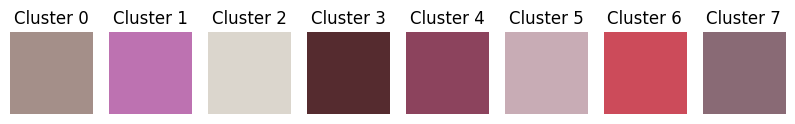

In [ ]:
# we now have the dominant color from each image in our csv
# we want to cluster across all images now to see color groups emerge!

# make sure our list of dominant colors is ready for kmeans
dominant_colors = np.array(dominant_colors)
print(dominant_colors.shape)

# cluster
kmeans_global = KMeans(n_clusters=8, random_state=25).fit(dominant_colors)
labels_global, centers_global = kmeans_global.labels_, kmeans_global.cluster_centers_

# LAB to RGB for display
centers_rgb = cv2.cvtColor(np.uint8(centers_global[np.newaxis, :, :]), cv2.COLOR_LAB2RGB)[0]

plt.figure(figsize=(10,2))
for i, color in enumerate(centers_rgb):
    patch = np.ones((50, 50, 3), dtype=np.uint8) * color
    plt.subplot(1, len(centers_rgb), i+1)
    plt.imshow(patch)
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.show()

Explained variance ratio: [    0.83422    0.098617]


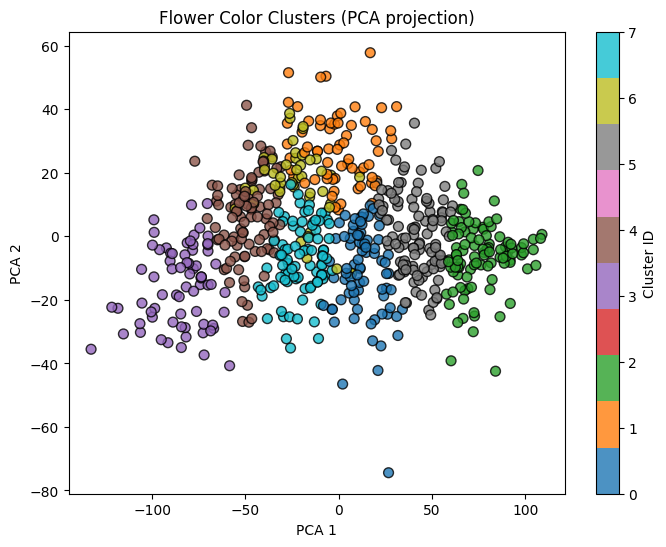

In [ ]:
# now we'll use PCA to reduce the dimensions of our clusters and visualize them
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lab_pca = pca.fit_transform(dominant_colors)
print("component-explained variance", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    lab_pca[:,0],
    lab_pca[:,1],
    c=labels_global,
    cmap="tab10",
    s=50,
    alpha=0.8,
    edgecolors='k'
)
plt.title("Flower Color Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

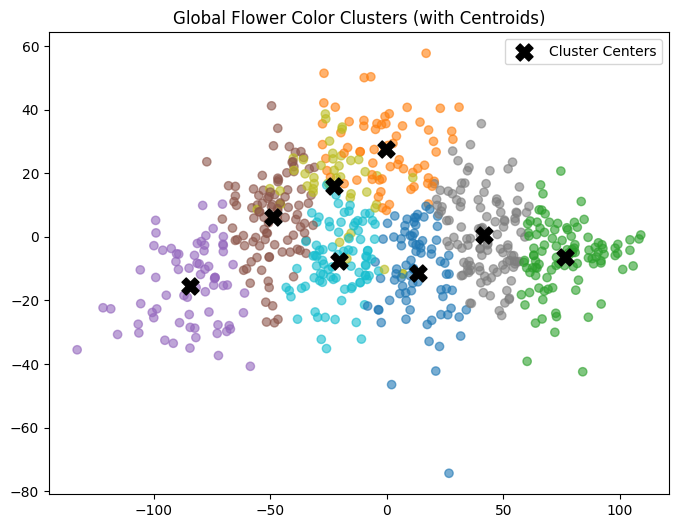

In [34]:
centers = kmeans_global.cluster_centers_
centers_pca = pca.transform(centers)

plt.figure(figsize=(8,6))
plt.scatter(lab_pca[:,0], lab_pca[:,1], c=labels_global, cmap="tab10", alpha=0.6)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', marker='X', s=150, label='Cluster Centers')
plt.legend()
plt.title("Global Flower Color Clusters (with Centroids)")
plt.show()

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


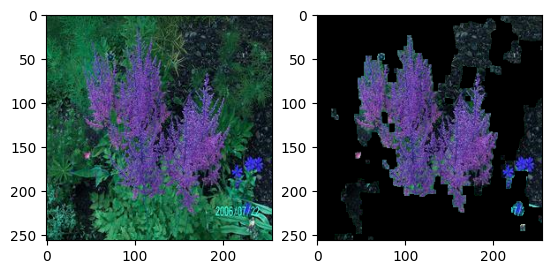

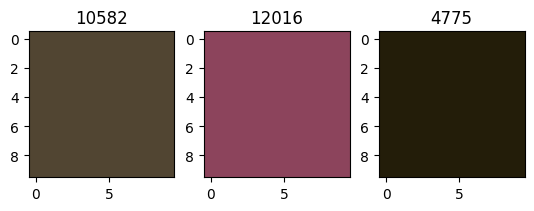

In [ ]:
## old function
def extract_flower_color(image_path):
    # read in image
    img_bgr = cv2.imread(image_path)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)  # convert to hsv

    # remove greens
    lower = np.array([35, 40, 40])  # remove green hues, between 35 and 85, also extremely dull colors
    upper = np.array([100, 255, 255])
    mask = cv2.inRange(img_hsv, lower, upper)
    mask = cv2.bitwise_not(mask)

    # cleanup and mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    segmented = cv2.bitwise_and(img_bgr,img_bgr,mask=mask)
    plt.subplot(1,2,1); plt.imshow(img_bgr)
    plt.subplot(1,2,2); plt.imshow(segmented)
    plt.show()

    # convert to LAB - better for distinguishing color similarities
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

    # extract pixels and flatten
    pixels = np.where(mask > 0)
    pixels_lab = img_hsv[pixels[0], pixels[1], :]
    #print(pixels_lab.shape)

    # apply kmeans
    kmeans = KMeans(n_clusters = k, random_state=25).fit(pixels_lab)
    labels, centers = kmeans.labels_, kmeans.cluster_centers_
    #print(labels, centers)

    # count how many pixels were clustered into each group
    counts = np.bincount(labels)
    #print(counts)

    # grab cenrtoids and counts
    centroids = []
    for cluster_index, count in enumerate(counts):
        centroids.append((centers[cluster_index], int(count)))

    for i in range(k):
        color = centroids[i][0]
        frequency = centroids[i][1]
        #print(frequency)
        color = np.uint8([[color]])
        rgb = cv2.cvtColor(color, cv2.COLOR_HSV2RGB)
        #print(rgb)
        box = np.zeros((10,10,3), dtype=np.uint8)
        box[:,:] = rgb

        plt.subplot(1,k,i+1); plt.imshow(box); plt.title(frequency)
        
    plt.show()

    return img_bgr, img_lab, centroids

k = 3

species = 'dandelion/'
image_paths = os.listdir(f'flowers')
print(image_paths)

for i in range(len(image_paths)):
    species = image_paths[i]
    species_list = os.listdir('flowers/' + species)
    for j in range(2):
        img_bgr, lab, centroids = extract_flower_color('flowers/' + species + '/'+species_list[j+3])
        #print(lab)
        break
    break
